### Dependencies & Prerequisites


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
tfd = tfp.distributions
tfpl = tfp.layers
%matplotlib inline

### GPU Acceleration

In [2]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


## Dataset

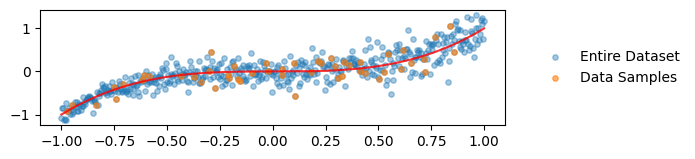

In [3]:
def load_dataset(n=500, ns=50):
  np.random.seed(44)
  x = np.linspace(-1, 1, n)
  y = np.power(x, 3) + 0.1 * (2 + x) * np.random.randn(n)
  rnd_idx = np.random.choice(len(x), ns, replace=False)
  xs = x[rnd_idx]
  ys = y[rnd_idx]
  x = x[..., np.newaxis]
  xs = xs[..., np.newaxis]
  return x, y, xs, ys

x, y, xs, ys = load_dataset()

# Set figure size
plt.figure(figsize=(6, 1.5))
# Plot data
plt.plot(x, np.power(x, 3), color='red', alpha=0.8)
plt.scatter(x, y, s=15, label="Entire Dataset", alpha=0.4)
plt.scatter(xs, ys, s=15, label="Data Samples", alpha=0.6)
# Add legend and show the plot
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
plt.show()

### BNN Model

In [4]:
# Define the negative log-likelihood function.
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [5]:
# Define the variational posterior weight distribution -- Multivariate Gaussian.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

In [6]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))),
    ])
    return prior_model

In [7]:
# Build model.
model = Sequential([
    tfpl.DenseVariational(units=8,
                          input_shape=(1, ),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x.shape[0]),
    tfpl.IndependentNormal(1)
])

# Compile model.
model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.005), loss=negloglik)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


In [8]:
def fit_model(iter, model, xs, ys, epochs=1000, verbose=False):
    # Fit model.
    model.fit(xs, ys, epochs=epochs, verbose=verbose);

    # Model predictions with uncertainty.
    yhat = model(x);
    mu = np.squeeze(yhat.mean());
    sigma = np.squeeze(yhat.stddev());

    # Evaluate acquisition function.
    plt.figure(figsize=[6, 1.5]); # inches
    plt.clf();
    plt.scatter(x, y, s=15, label="Entire Dataset", alpha=0.4);
    plt.scatter(xs, ys, s=15, label="Data Samples", alpha=0.6);
    plt.scatter(x, yhat.sample(), c='m', s=15, label="Model Predictions", alpha=0.4);
    plt.plot(x, mu, 'r', label='$\mu$', linewidth=1, alpha=1);
    data = x.copy()
    plt.fill_between(data.reshape(data.shape[0]), mu-2*sigma, mu+2*sigma, color='lawngreen', label='$\mu\pm2\sigma$', alpha=0.3);
    ax=plt.gca();
    ax.xaxis.set_ticks_position('bottom');
    ax.yaxis.set_ticks_position('left');
    ax.spines['left'].set_position(('data', 0));
    ax.spines['top'].set_visible(False);
    ax.spines['right'].set_visible(False);
    plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5));
    plt.title("Iteration {}".format(iter+1))

    return mu, sigma;

### Active Sampling

C:\Users\tsamak\AppData\Local\Temp\ipykernel_34920\363435000.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[6, 1.5]); # inches


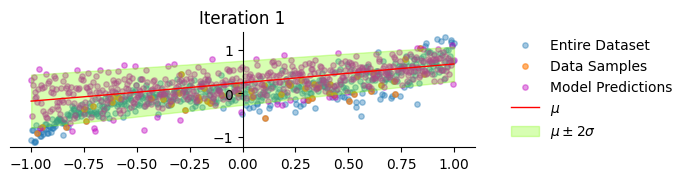

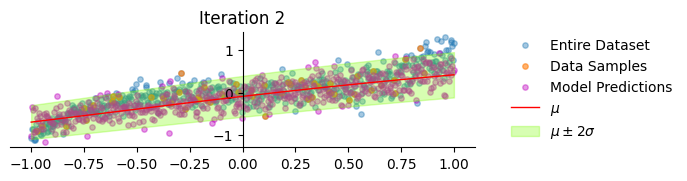

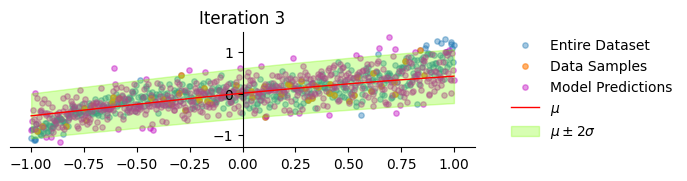

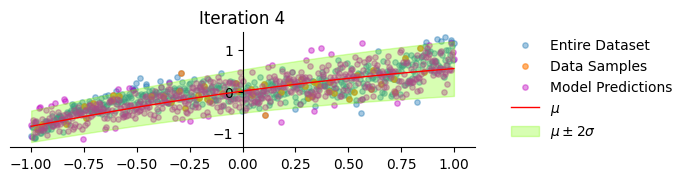

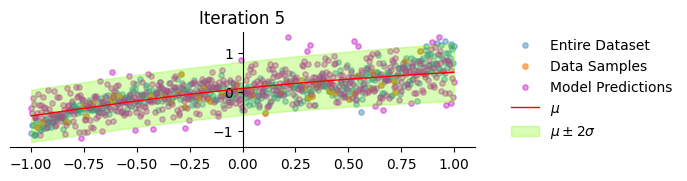

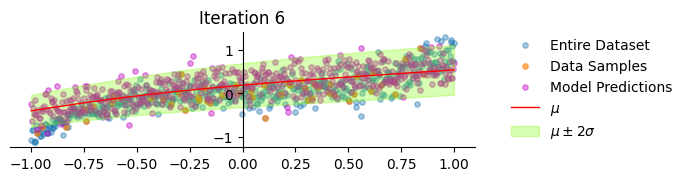

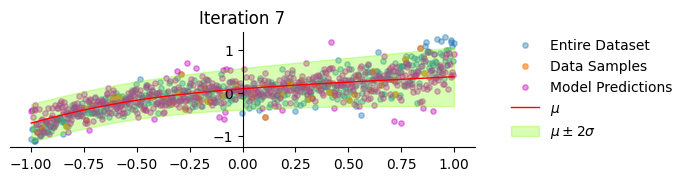

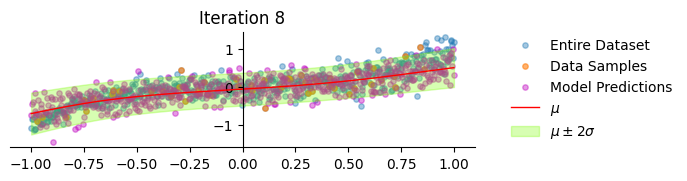

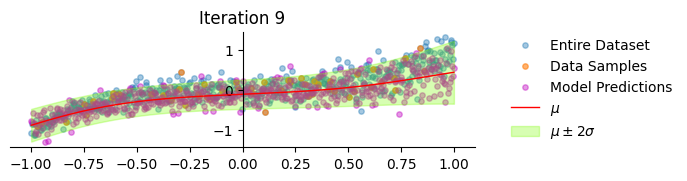

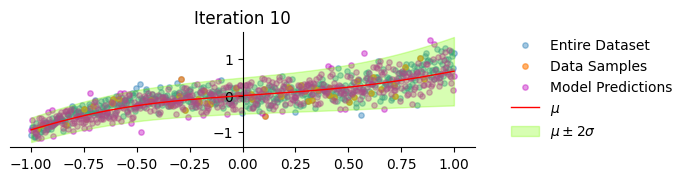

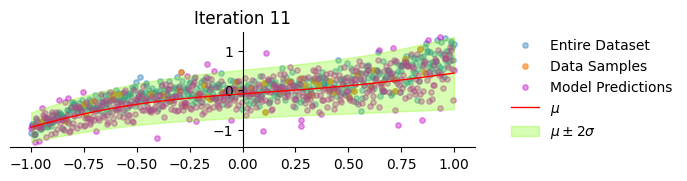

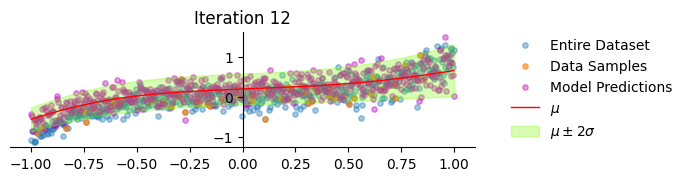

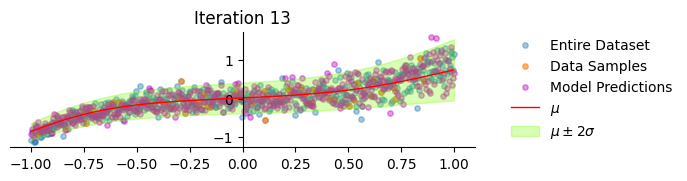

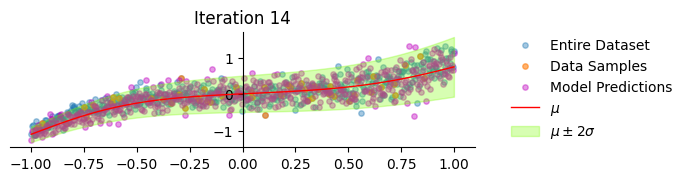

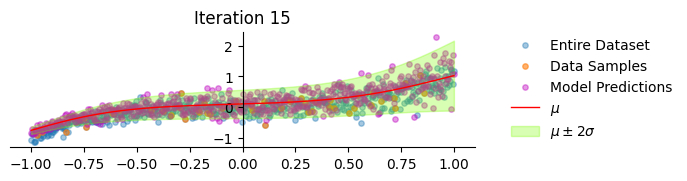

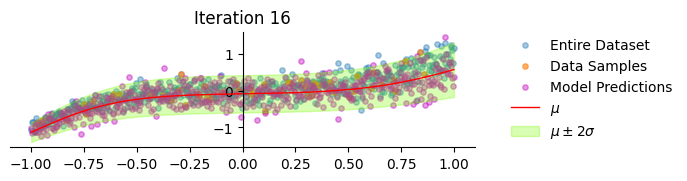

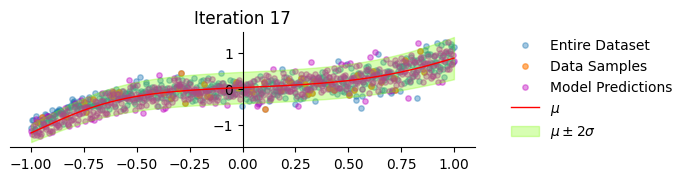

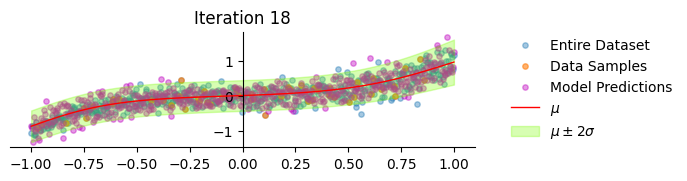

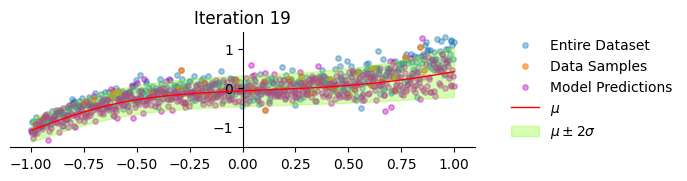

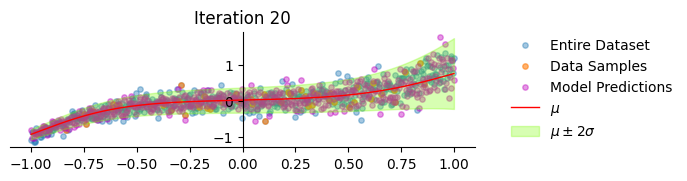

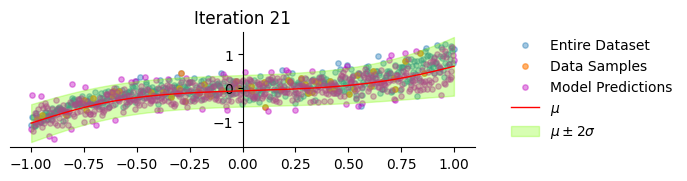

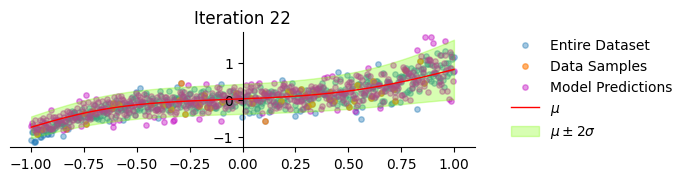

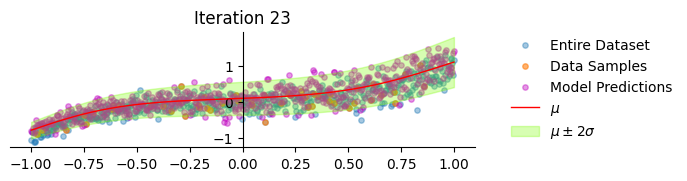

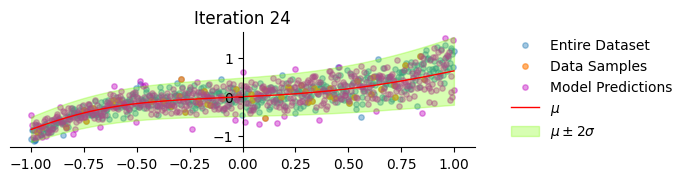

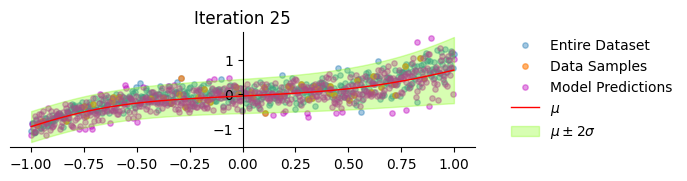

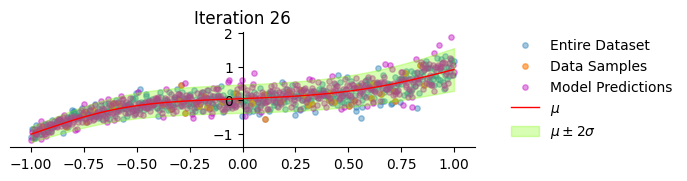

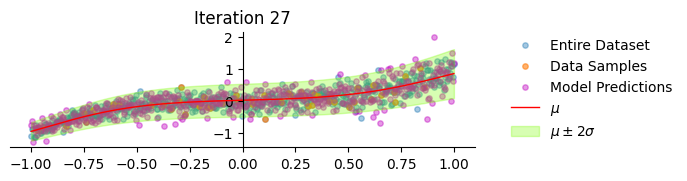

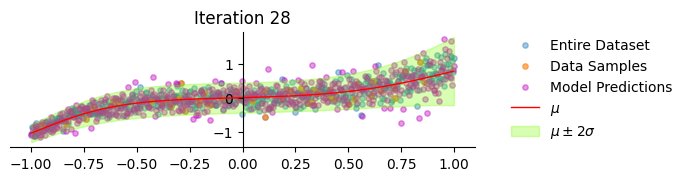

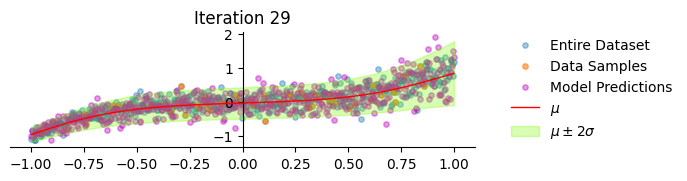

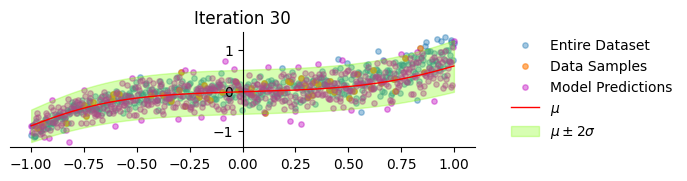

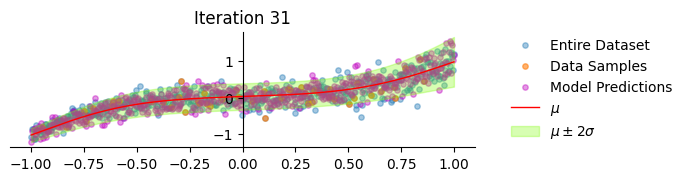

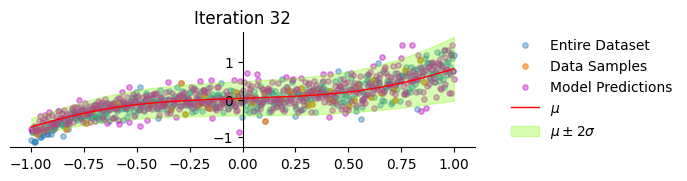

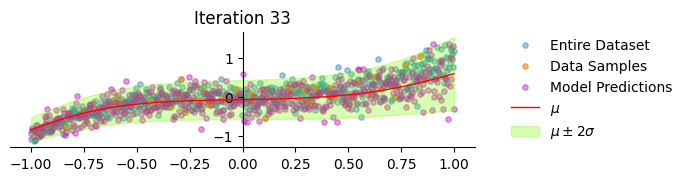

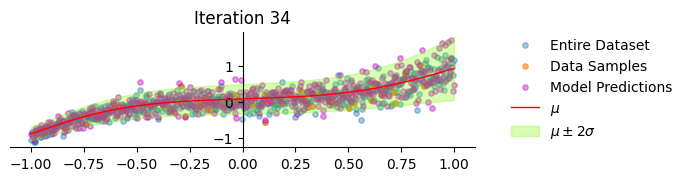

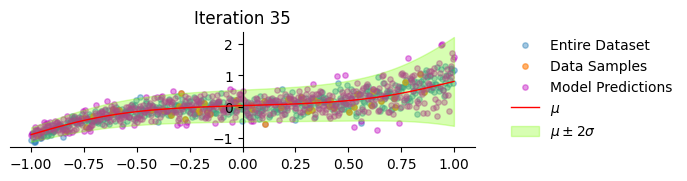

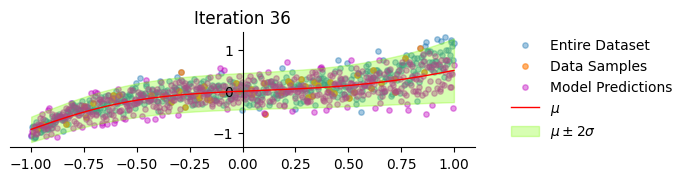

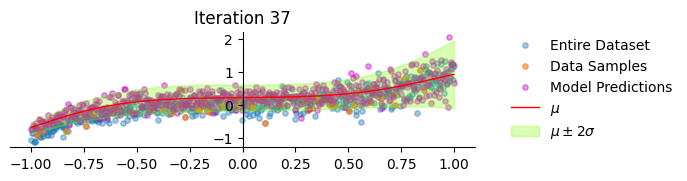

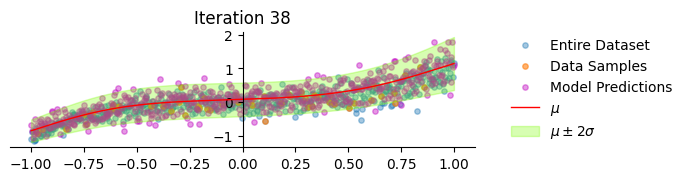

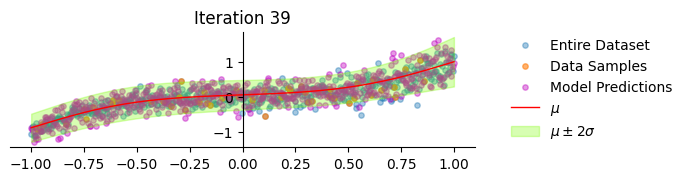

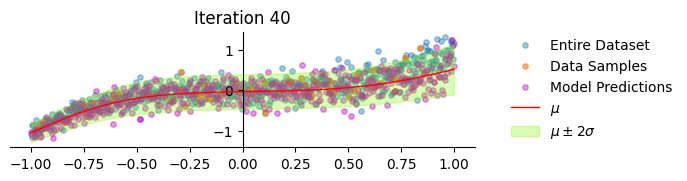

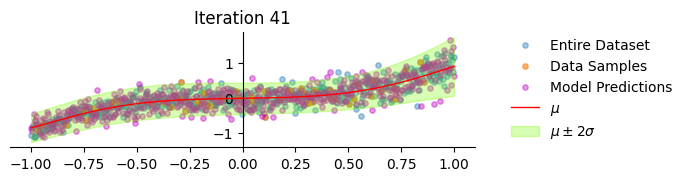

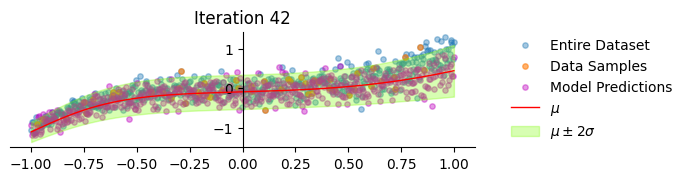

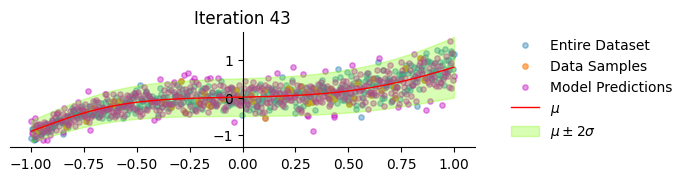

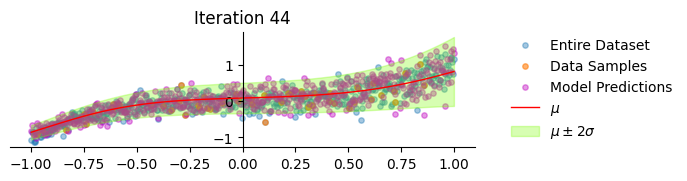

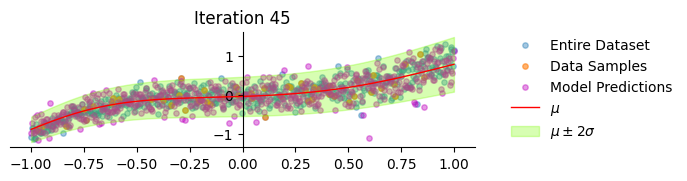

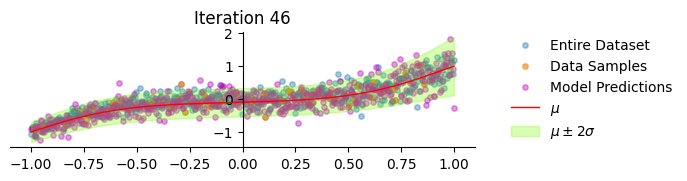

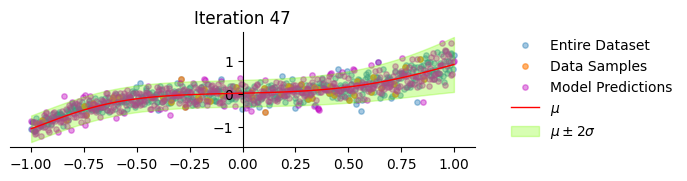

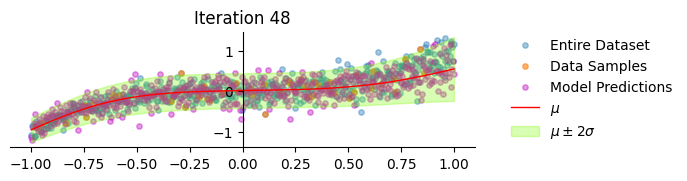

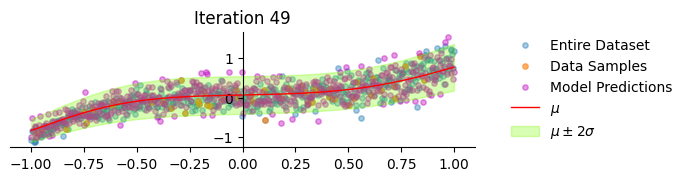

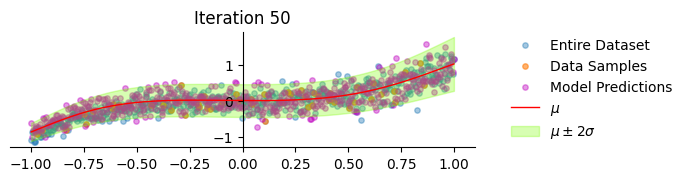

In [9]:
for i in range(50):
    # Train BNN model and visualize predictions
    mu, sigma = fit_model(i, model, xs, ys, epochs=1000, verbose=False);

    # Acquisition functions.
    kappa = 2;
    # lcb = mu - kappa * sigma;
    ucb = mu + kappa * sigma;

    # a = np.std(np.asarray(means), axis=0); # Acquisition function (max epistemic uncertainty)
    next_i = np.where(ucb == max(ucb))[0][0]; # Sample index based on acquisition function
    np.insert(xs, 0, x[next_i]); # Add next sample to XS
    np.insert(ys, 0, y[next_i]); # Add next sample to YS